# OHP_1_PreProcessingMasterBiasMasterFlats
[Version Hervé Dole, Université Paris-Saclay - 20240324]

Thanks to Henry J McCracken and M2 astrophysique AAIS IDF OHP1 team for inspiration on some code lines

Génère les master Bias et master flat

Pré-processe tous les fichiers d'un filtre donné

Divise par le temps d'exposition pour rescaler à 1s de pose à la fin (utile pour future calibration photométrique)

In [315]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os 
import glob
import astropy
from astropy.io import fits
import pathlib

### Define here working directories

In [316]:
data_dir = "./data/"
data_dir2 = "./data2/"
data_dir3 = "./data3/"
output_dir = "./"

### Define filenames here [choose only one filter at a time, e.g. r or g]

In [317]:
# Inputs
input_bias_list = data_dir + 'biais*fits'

# filtre r
input_flat_list = data_dir +'Flat*R.fits'
input_data_list = data_dir3 + 'PSZ1-cluster*_R.fits'

# filtre g
#input_flat_list = data_dir + 'Flat*G.fits'
#input_data_list = data_dir3 + 'PSZ1-cluster*_G.fits'

In [318]:
# Outputs
masterbias_outfile = output_dir+'final_bias.fits'

# filtre r
masterflat_outfile = output_dir+'master_flat_R_T120.fits'

# filtre g
#masterflat_outfile = output_dir+'master_flat_G_T120.fits'

processed_data_outfile = '_processed'

## 1. Bias frames -> generate SuperBias

In [319]:
# list bias frames
bias_list = glob.glob(input_bias_list)
print (np.size(bias_list))

11


In [320]:
# check bias frames list
bias_list

['./data/biais-00110.fits',
 './data/biais-00080.fits',
 './data/biais-00100.fits',
 './data/biais-00090.fits',
 './data/biais-00030.fits',
 './data/biais-00010.fits',
 './data/biais-00050.fits',
 './data/biais-00070.fits',
 './data/biais-00020.fits',
 './data/biais-00060.fits',
 './data/biais-00040.fits']

In [321]:
# stack frames and take media to create superbias
images = np.stack([fits.getdata(bias).astype(np.float32) for bias in bias_list], axis=2)
final_bias = np.median(images, axis=2)

In [322]:
# write superbias fits file
hdu = fits.PrimaryHDU(final_bias)
hdu.writeto(masterbias_outfile, overwrite=True)

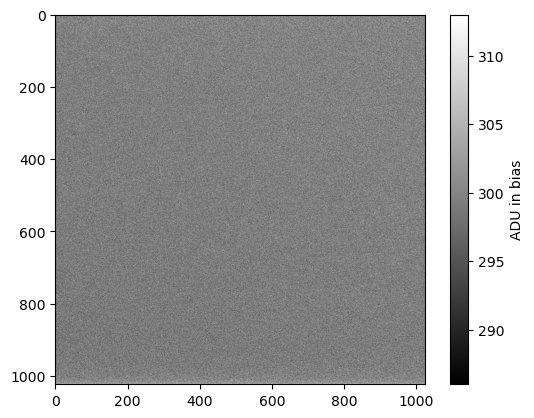

In [323]:
# Show superbias
plt.imshow(final_bias, cmap='gray')
plt.colorbar(label="ADU in bias")

In [324]:
# Show superbias statistics - for checks
print("median: ", np.median(final_bias))
print("mean: ", np.mean(final_bias))
print("stdev: ", np.std(final_bias))
print("min: ", np.min(final_bias))
print("max: ", np.max(final_bias))

median:  299.0
mean:  299.4191
stdev:  2.7347305
min:  286.0
max:  313.0


In [325]:
# Show superbias histogram - for checks
#nbins=10
#plt.hist(final_bias, bins=nbins)
#plt.show()

## 2. Flat frames -> generate SuperFlat in a given filter

In [326]:
# list flat frames
flat_list = glob.glob(input_flat_list)
print (np.size(flat_list))

7


In [327]:
# check flat frames list
flat_list

['./data/Flat-0007_R.fits',
 './data/Flat-0005_R.fits',
 './data/Flat-0001_R.fits',
 './data/Flat-0003_R.fits',
 './data/Flat-0006_R.fits',
 './data/Flat-0004_R.fits',
 './data/Flat-0002_R.fits']

In [328]:
# stack frames and take media to create superbias
images = np.stack([fits.getdata(flat).astype(np.float32) - final_bias for flat in flat_list], axis=2)
flat_in = np.median(images, axis=2)

In [329]:
# normalize final flat to 1
final_flat = flat_in/np.mean(flat_in) 

In [330]:
# write superflat in fits
hdu = fits.PrimaryHDU(final_flat)
hdu.writeto(masterflat_outfile, overwrite=True)

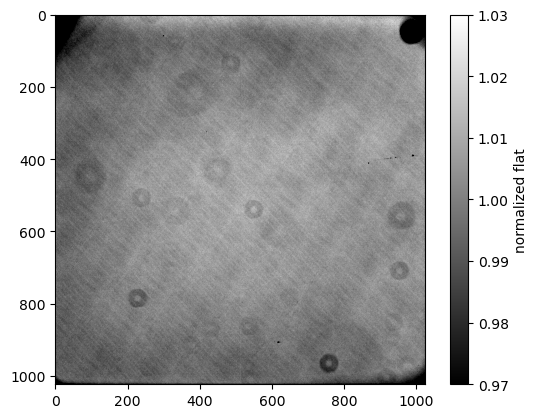

In [331]:
# Show superflat
plt.imshow(final_flat, cmap='gray', vmin=0.97,vmax=1.03)
plt.colorbar(label="normalized flat")

In [332]:
# Show superflat statistics - for checks
print("median: ", np.median(final_flat))
print("mean: ", np.mean(final_flat))
print("stdev: ", np.std(final_flat))
print("min: ", np.min(final_flat))
print("max: ", np.max(final_flat))

median:  1.0011284
mean:  0.9999995
stdev:  0.011166607
min:  0.7203059
max:  1.0314821


## 3. Apply masterbias and masterflat to data -> generate all processed data in a given filter and divide by exposure time

In [333]:
image_list = glob.glob(input_data_list)
np.size(image_list)

4

In [334]:
image_list

['./data3/PSZ1-cluster-0007_R.fits',
 './data3/PSZ1-cluster-0001_R.fits',
 './data3/PSZ1-cluster-0006_R.fits',
 './data3/PSZ1-cluster-0002_R.fits']

In [335]:
# Process all data image : apply masterbias and masterflat
# and divide by exposure time ins econd to get -> 1s (important for photometric calibration later)
output_file_list = [] 
for image in image_list:
    # Apply masterbias and masterflat
    processed = (fits.getdata(image)-final_bias)/final_flat
    # Get exposure time
    exptime = fits.getval(image,'EXPTIME')
    # Divide by exposure time
    processed = processed / exptime
    # Generate output filename 
    filename,file_extension=os.path.splitext(image)
    outfile=output_dir+os.path.basename(filename)+processed_data_outfile+'.fits'
    hdu = fits.PrimaryHDU(processed)
    # Update minimalist Header
    hdr = hdu.header
    hdr['HISTORY'] = 'Written by OHP_1_PreProcessingMasterBiasMasterFlats'
    hdr['HISTORY'] = 'Divided by exposure time -> now 1s'
    # Write output fits file 
    hdu.writeto(outfile, overwrite=True)
    print(outfile, exptime)
    output_file_list.append(outfile)

./PSZ1-cluster-0007_R_processed.fits 200.0
./PSZ1-cluster-0001_R_processed.fits 200.0
./PSZ1-cluster-0006_R_processed.fits 200.0
./PSZ1-cluster-0002_R_processed.fits 200.0


In [336]:
#output_file_list

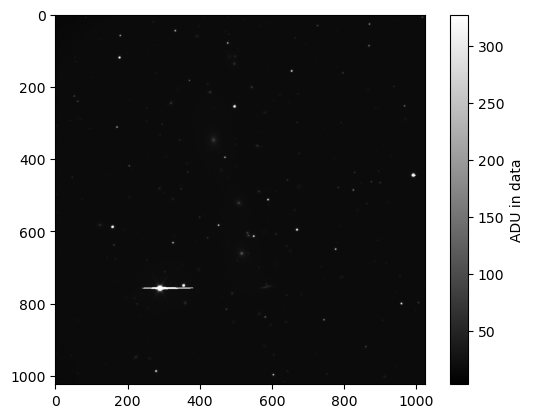

In [337]:
# Show first datafile without cut
processed = (fits.getdata(output_file_list[0]))
plt.imshow(processed, cmap='gray')
plt.colorbar(label="ADU in data")

In [338]:
# Show data statistics - for checks
print("median: ", np.median(processed))
print("mean: ", np.mean(processed))
print("stdev: ", np.std(processed))
print("min: ", np.min(processed))
print("max: ", np.max(processed))

median:  17.830622
mean:  18.373463
stdev:  9.799912
min:  3.1800156
max:  327.62933


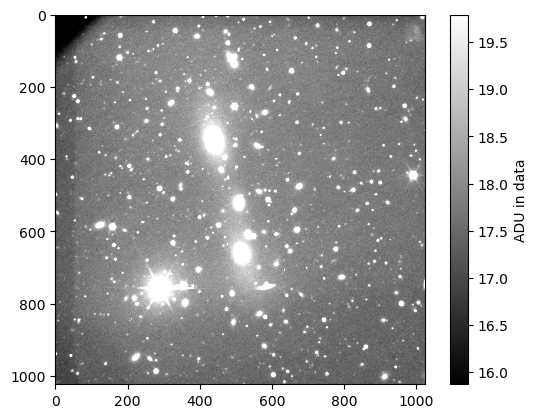

In [339]:
# Show first datafile with better cut
sig = 0.2
m, s = np.median(processed), np.std(processed)
plt.imshow(processed, cmap='gray', vmin=m-sig*s, vmax=m+sig*s)
plt.colorbar(label="ADU in data")